In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
AIF360_AVAILABLE = False
try:
    from aif360.datasets import StandardDataset
    from aif360.algorithms.preprocessing import Reweighing
    AIF360_AVAILABLE = True
except Exception as e:
    print("aif360 not available (or optional dependencies missing). Skipping bias mitigation.")

df = pd.read_csv('marketing_campaign.csv', sep='\t')
print("Original dataset shape:", df.shape)
df.columns
df.info()
df.isnull().sum()



Original dataset shape: (2240, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  Num

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [17]:
# Drop missing Income
df = df.dropna(subset=['Income'])

# Age
current_year = datetime.now().year
df["Age"] = current_year - df["Year_Birth"]

# >>> YOUR CLEANING STEPS <<<
age_over_100 = df[df["Age"] > 100]
print(f"Number of records with Age > 100: {len(age_over_100)}")
df_c = df[df["Age"] <= 100].copy()

df_c["Marital_Status"] = df_c["Marital_Status"].replace(
    {"Absurd": "Others", "YOLO": "Others", "Alone": "Others"}
)

print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_c.shape}")


Number of records with Age > 100: 3
Original dataset shape: (2216, 30)
Cleaned dataset shape: (2213, 30)


In [18]:
# Feature Engineering
df_c["Education"] = df_c["Education"].replace({
    "Basic": "Undergraduate", "2n Cycle": "Undergraduate",
    "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"
})
df_c["Living_With"] = df_c["Marital_Status"].replace({
    "Married": "Partner", "Together": "Partner",
    "Single": "Alone", "Divorced": "Alone", "Widow": "Alone", "Others": "Alone"
})
df_c["Has_Children"] = ((df_c["Kidhome"] + df_c["Teenhome"]) > 0).astype(int)
df_c["TotalMnt"] = df_c[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)
df_c["TotalPurchases"] = df_c[['NumWebPurchases','NumCatalogPurchases','NumStorePurchases']].sum(axis=1)
df_c["TotalAcceptedCmp"] = df_c[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response']].sum(axis=1)
df_c["Dt_Customer"] = pd.to_datetime(df_c["Dt_Customer"], format='%d-%m-%Y')
df_c["Days_Customer"] = (datetime.now() - df_c["Dt_Customer"]).dt.days

# Final features
features = ['Age', 'Income', 'Has_Children', 'TotalMnt', 'TotalPurchases',
            'NumWebVisitsMonth', 'TotalAcceptedCmp', 'Days_Customer']
df_final = df_c[features].copy()


=== DETAILED SUPERVISED MODEL EVALUATION ===

🔍 Random Forest
--------------------------------------------------
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00       188
      Medium       1.00      1.00      1.00       183
        High       1.00      1.00      1.00       183

    accuracy                           1.00       554
   macro avg       1.00      1.00      1.00       554
weighted avg       1.00      1.00      1.00       554



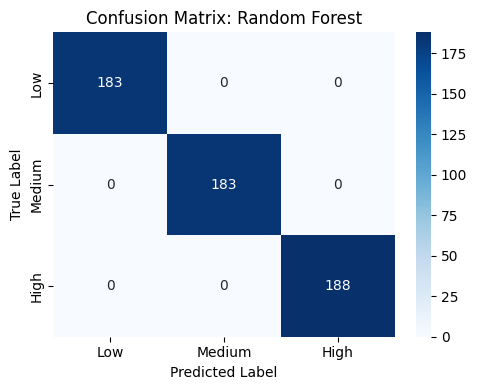



🔍 XGBoost
--------------------------------------------------
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00       188
      Medium       0.98      1.00      0.99       183
        High       1.00      0.98      0.99       183

    accuracy                           0.99       554
   macro avg       0.99      0.99      0.99       554
weighted avg       0.99      0.99      0.99       554



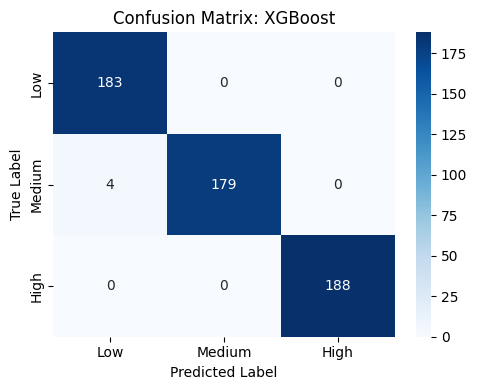



🔍 Logistic Regression
--------------------------------------------------
              precision    recall  f1-score   support

         Low       0.99      0.96      0.98       188
      Medium       0.99      1.00      0.99       183
        High       0.96      0.98      0.97       183

    accuracy                           0.98       554
   macro avg       0.98      0.98      0.98       554
weighted avg       0.98      0.98      0.98       554



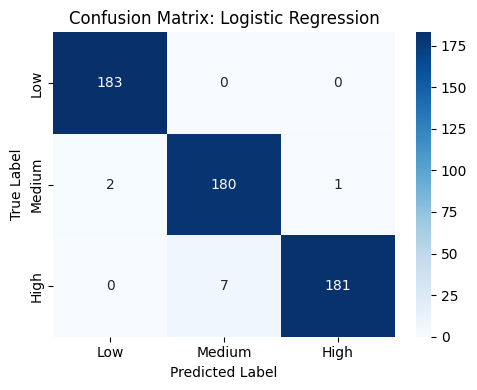



🔍 KNN
--------------------------------------------------
              precision    recall  f1-score   support

         Low       0.93      0.95      0.94       188
      Medium       0.80      0.91      0.85       183
        High       0.84      0.70      0.76       183

    accuracy                           0.86       554
   macro avg       0.86      0.85      0.85       554
weighted avg       0.86      0.86      0.85       554



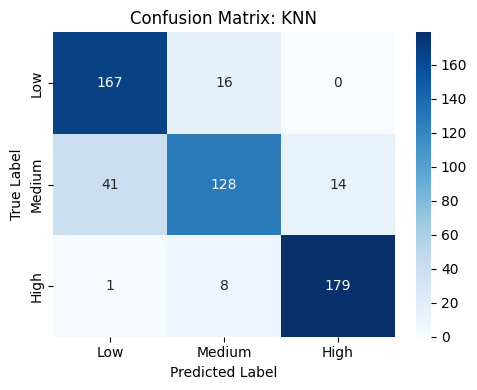




📊 SUPERVISED MODELS: PERFORMANCE SUMMARY
              Model  Accuracy  Macro F1  Weighted F1  Low F1  Medium F1  High F1
      Random Forest    1.0000    1.0000       1.0000  1.0000     1.0000   1.0000
            XGBoost    0.9928    0.9927       0.9928  1.0000     0.9892   0.9890
Logistic Regression    0.9819    0.9820       0.9819  0.9784     0.9946   0.9730
                KNN    0.8556    0.8520       0.8527  0.9396     0.8520   0.7642

✅ Bias mitigation applied.


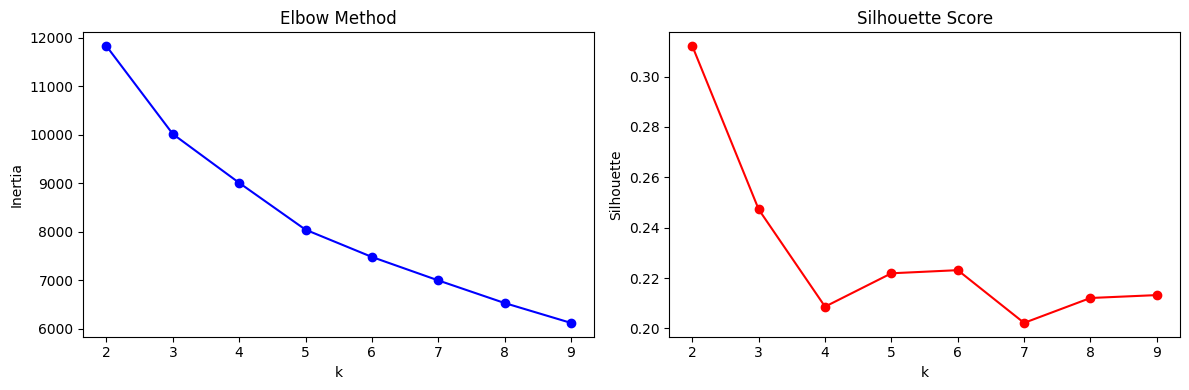


=== UNSUPERVISED CLUSTERING RESULTS ===
KMeans → Clusters: 2, Silhouette: 0.312, CH: 1042.8, ARI: 0.452
GMM → Clusters: 2, Silhouette: 0.255, CH: 628.2, ARI: 0.258
Agglomerative → Clusters: 2, Silhouette: 0.293, CH: 989.4, ARI: 0.420
DBSCAN → Clusters: 21, Silhouette: -0.416, CH: 18.6, ARI: 0.108

Unsupervised Results Summary:
               Clusters  Silhouette  CH Index  ARI vs True Segments
KMeans              2.0       0.312  1042.834                 0.452
GMM                 2.0       0.255   628.229                 0.258
Agglomerative       2.0       0.293   989.378                 0.420
DBSCAN             21.0      -0.416    18.579                 0.108


In [19]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture  
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score, adjusted_rand_score 
from sklearn.metrics import calinski_harabasz_score, silhouette_score, adjusted_rand_score


# Create Supervised Labels (Segments
q33, q66 = df_final['TotalMnt'].quantile([0.33, 0.66])
def segment(mnt):
    if mnt <= q33: return 'Low'
    elif mnt <= q66: return 'Medium'
    else: return 'High'
df_final['Segment'] = df_final['TotalMnt'].apply(segment)
y_seg = df_final['Segment']
X = df_final[features]

# Feature Selection
selector = SelectKBest(f_classif, k=8)
X_sel = selector.fit_transform(X, y_seg)
selected_features = X.columns[selector.get_support()].tolist()
X = X[selected_features]

#Supervised Learning:
from sklearn.metrics import classification_report, confusion_matrix

label_map = {'Low': 0, 'Medium': 1, 'High': 2}
y = y_seg.map(label_map)
y_labels = y_seg  # keep original string labels for reporting

X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(
    X, y, y_seg, test_size=0.25, stratify=y, random_state=42
)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

detailed_reports = {}

print("=== DETAILED SUPERVISED MODEL EVALUATION ===\n")

for name, model in models.items():
    print(f"🔍 {name}")
    print("-" * 50)
    
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_labels = pd.Series(y_pred).map({v: k for k, v in label_map.items()})
    
    # Classification report (with labels)
    report = classification_report(
        y_test_labels, y_pred_labels,
        target_names=['Low', 'Medium', 'High'],
        output_dict=True
    )
    detailed_reports[name] = report
    
    # Print human-readable report
    print(classification_report(
        y_test_labels, y_pred_labels,
        target_names=['Low', 'Medium', 'High']
    ))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=['Low', 'Medium', 'High'])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print("\n")

# Optional: Summarize key metrics in a table
summary_metrics = []
for model_name, report in detailed_reports.items():
    summary_metrics.append({
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Macro F1': report['macro avg']['f1-score'],
        'Weighted F1': report['weighted avg']['f1-score'],
        'Low F1': report['Low']['f1-score'],
        'Medium F1': report['Medium']['f1-score'],
        'High F1': report['High']['f1-score']
    })

summary_df = pd.DataFrame(summary_metrics)
print("\n📊 SUPERVISED MODELS: PERFORMANCE SUMMARY")
print(summary_df.round(4).to_string(index=False))

# Bias Mitigation
if AIF360_AVAILABLE:
    df_aif = df_final.copy()
    df_aif['Segment_encoded'] = df_aif['Segment'].map(label_map)
    numeric_df = df_aif.select_dtypes(include=[np.number])
    try:
        ds = StandardDataset(
            df=numeric_df,
            label_name='Segment_encoded',
            favorable_classes=[2],
            protected_attribute_names=['Has_Children'],
            privileged_classes=[[0]]
        )
        RW = Reweighing(unprivileged_groups=[{'Has_Children': 1}], privileged_groups=[{'Has_Children': 0}])
        _ = RW.fit_transform(ds)
        print("\n✅ Bias mitigation applied.")
    except Exception as e:
        print(f"\n⚠️ Bias mitigation failed: {e}")
else:
    print("\nSkipping bias mitigation (aif360 not available).")

# Unsupervised Clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Elbow + Silhouette for KMeans
Ks = range(2, 10)
inertias, sils = [], []
for k in Ks:
    km = KMeans(k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_pca, labels))

optimal_k = Ks[np.argmax(sils)]

# Plot Elbow & Silhouette
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(Ks, inertias, 'bo-'); plt.title('Elbow Method'); plt.xlabel('k'); plt.ylabel('Inertia')
plt.subplot(1, 2, 2)
plt.plot(Ks, sils, 'ro-'); plt.title('Silhouette Score'); plt.xlabel('k'); plt.ylabel('Silhouette')
plt.tight_layout()
plt.show()

clustering_algos = {
    "KMeans": KMeans(n_clusters=optimal_k, random_state=42, n_init=10),
    "GMM": GaussianMixture(n_components=optimal_k, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=optimal_k),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5)
}

unsupervised_results = {}
print("\n=== UNSUPERVISED CLUSTERING RESULTS ===")
for name, algo in clustering_algos.items():
    labels = algo.fit_predict(X_pca)
    
    # Skip if DBSCAN yields <2 clusters
    unique_labels = set(labels)
    if name == "DBSCAN" and (len(unique_labels) < 2 or (-1 in unique_labels and len(unique_labels) == 2)):
        print(f"{name} → Too few clusters (likely noise-dominated). Skipped.")
        continue
        
    n_clust = len(unique_labels) - (1 if -1 in unique_labels else 0) if name == "DBSCAN" else optimal_k
    sil = silhouette_score(X_pca, labels)
    ch = calinski_harabasz_score(X_pca, labels)
    ari = adjusted_rand_score(y, labels)  # compare to true segments
    unsupervised_results[name] = {
        "Clusters": n_clust,
        "Silhouette": sil,
        "CH Index": ch,
        "ARI vs True Segments": ari
    }
    print(f"{name} → Clusters: {n_clust}, Silhouette: {sil:.3f}, CH: {ch:.1f}, ARI: {ari:.3f}")

unsup_df = pd.DataFrame(unsupervised_results).T
print("\nUnsupervised Results Summary:")
print(unsup_df.round(3))

best_algo = unsup_df['Silhouette'].idxmax()
best_labels = clustering_algos[best_algo].fit_predict(X_pca)
df_final['BestCluster'] = best_labels

In [20]:
# Save Models for Deployment (Streamlit / Production)
import os
import joblib

# Ensure models directory exists
os.makedirs('models', exist_ok=True)

# 1. Save the scaler (already fitted in unsupervised section)
joblib.dump(scaler, 'models/scaler.pkl')

# 2. Save the PCA transformer (already fitted)
joblib.dump(pca, 'models/pca.pkl')

# 3. Save the BEST clustering model (refit it to ensure it's trained on full data)
best_model = clustering_algos[best_algo]
# Refit on full X_pca to ensure it's trained on all data (not just a subset)
best_model.fit(X_pca)
joblib.dump(best_model, 'models/clusterer.pkl')

# 4. Save feature order (critical for Streamlit input alignment)
with open('models/feature_order.txt', 'w') as f:
    f.write('\n'.join(X.columns.tolist()))

# 5. Save cluster profiles for interpretation
df_radar = df_final.copy()
from sklearn.preprocessing import MinMaxScaler as MMScaler
scaler_radar = MMScaler()
df_radar[X.columns] = scaler_radar.fit_transform(df_final[X.columns])
cluster_profiles = df_radar.groupby('BestCluster')[X.columns].mean()
cluster_profiles.to_csv('models/cluster_profiles.csv')

print(f"\n✅ Deployment artifacts saved to 'models/' folder:")
print(f"   - scaler.pkl          (StandardScaler)")
print(f"   - pca.pkl             (PCA transformer)")
print(f"   - clusterer.pkl       (Best clustering model: {best_algo})")
print(f"   - feature_order.txt   (Input feature order)")
print(f"   - cluster_profiles.csv (Normalized cluster behavior)")


✅ Deployment artifacts saved to 'models/' folder:
   - scaler.pkl          (StandardScaler)
   - pca.pkl             (PCA transformer)
   - clusterer.pkl       (Best clustering model: KMeans)
   - feature_order.txt   (Input feature order)
   - cluster_profiles.csv (Normalized cluster behavior)


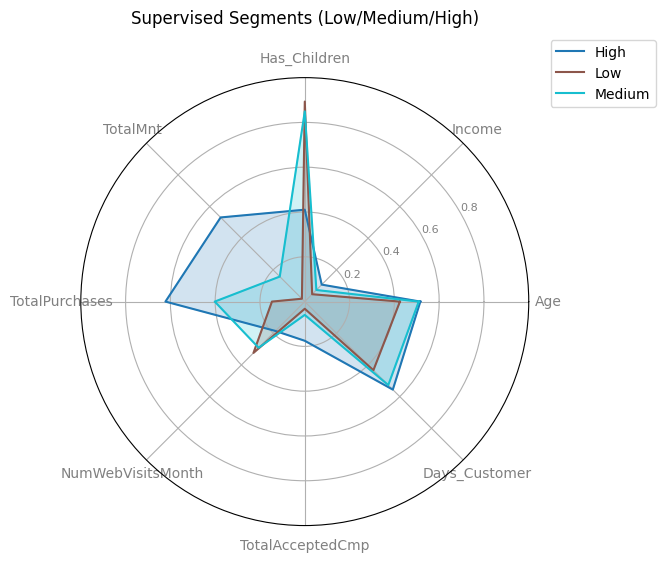

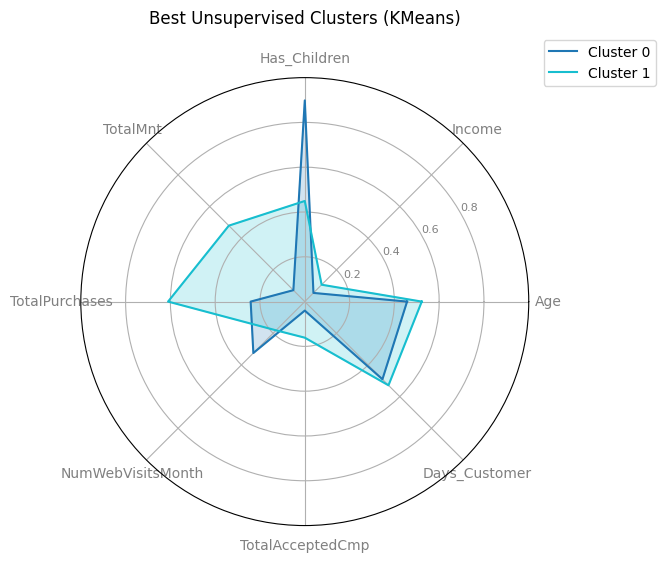

In [ ]:
#  Radar Charts
scaler_radar = MinMaxScaler()
df_radar = df_final.copy()
df_radar[selected_features] = scaler_radar.fit_transform(df_final[selected_features])

# Segment profile
seg_prof = df_radar.groupby('Segment')[selected_features].mean()
# Cluster profile (best model)
clust_prof = df_radar.groupby('BestCluster')[selected_features].mean()
clust_prof.index = [f"Cluster {i}" for i in clust_prof.index]

def plot_radar(df, title):
    cats = df.columns
    N = len(cats)
    angles = [n / N * 2 * np.pi for n in range(N)] + [0]
    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], cats, color='grey', size=10)
    ax.set_rlabel_position(30)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)
    colors = plt.cm.tab10(np.linspace(0,1,len(df)))
    for i, (name, row) in enumerate(df.iterrows()):
        vals = row.tolist() + [row.iloc[0]]
        ax.plot(angles, vals, label=name, color=colors[i])
        ax.fill(angles, vals, color=colors[i], alpha=0.2)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title(title, pad=20)
    plt.tight_layout()
    plt.show()

plot_radar(seg_prof, "Supervised Segments (Low/Medium/High)")
plot_radar(clust_prof, f"Best Unsupervised Clusters ({best_algo})")


🔍 Individual Segment Profiles:


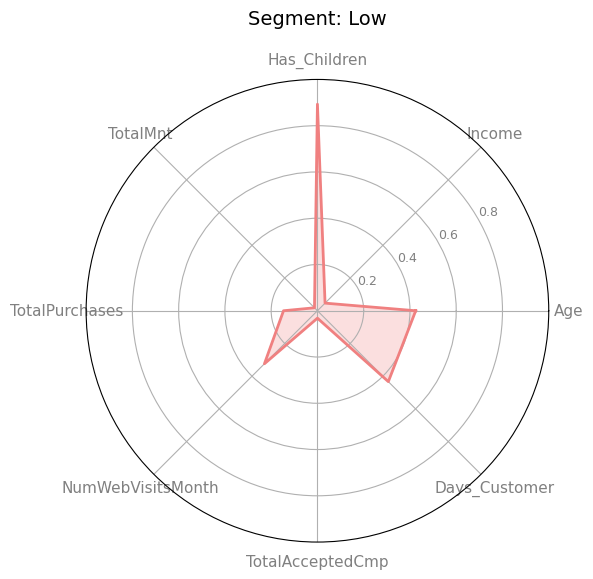

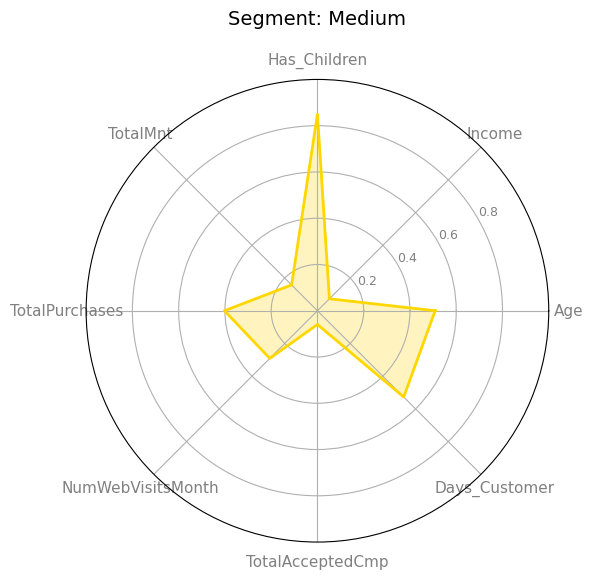

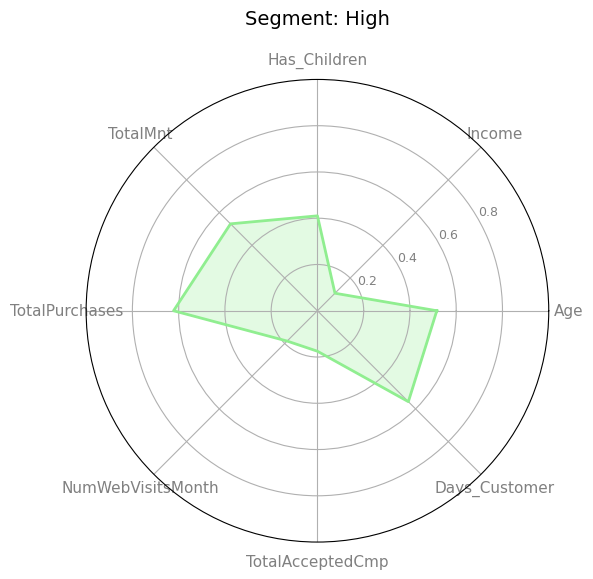

🔍 Individual Cluster Profiles:


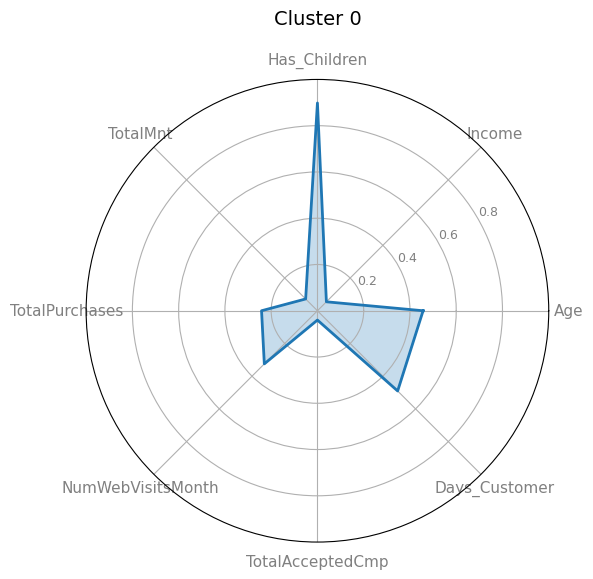

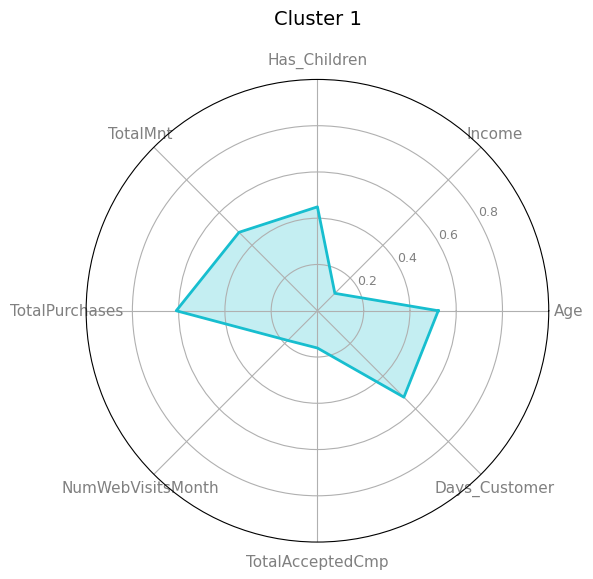

In [22]:
# Individual Radar Charts
scaler_radar = MinMaxScaler()
df_radar = df_final.copy()
df_radar[selected_features] = scaler_radar.fit_transform(df_final[selected_features])

def plot_single_radar(values, categories, title, color='steelblue'):
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # close the loop
    values = np.concatenate((values, [values[0]]))

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=11)
    ax.set_rlabel_position(30)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=9)
    plt.ylim(0, 1)

    ax.plot(angles, values, linewidth=2, linestyle='solid', color=color)
    ax.fill(angles, values, color=color, alpha=0.25)
    plt.title(title, size=14, pad=20)
    plt.tight_layout()
    plt.show()

# Get normalized profiles
segment_profile = df_radar.groupby('Segment')[selected_features].mean()
cluster_profile = df_radar.groupby('BestCluster')[selected_features].mean()

# Colors for consistency
segment_colors = {'Low': 'lightcoral', 'Medium': 'gold', 'High': 'lightgreen'}
cluster_colors = plt.cm.tab10(np.linspace(0, 1, len(cluster_profile)))

# Plot each supervised segment
print("🔍 Individual Segment Profiles:")
for segment in ['Low', 'Medium', 'High']:
    if segment in segment_profile.index:
        vals = segment_profile.loc[segment].values
        plot_single_radar(
            vals,
            selected_features,
            f"Segment: {segment}",
            color=segment_colors[segment]
        )

# Plot each unsupervised cluster
print("🔍 Individual Cluster Profiles:")
for i, cluster_id in enumerate(cluster_profile.index):
    vals = cluster_profile.loc[cluster_id].values
    plot_single_radar(
        vals,
        selected_features,
        f"Cluster {cluster_id}",
        color=cluster_colors[i % 10]
    )

In [23]:
# ================================================================
# 🔹 FEATURE IMPORTANCE (from best supervised model)
# ================================================================

# Choose the best-performing model (highest accuracy)
best_model_name = max(supervised_results, key=supervised_results.get)
best_model = models[best_model_name]  # Assuming you stored models in a dict called `models`

# Try to extract feature importances safely
try:
    importances = best_model.feature_importances_
    feature_names = X_train.columns  # or the correct list of features you used
    imp_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).reset_index(drop=True)

except AttributeError:
    # Some models (like Logistic Regression or SVM) don't have feature_importances_
    print(f"⚠️ {best_model_name} does not support feature_importances_.")
    imp_df = pd.DataFrame(columns=["Feature", "Importance"])


In [24]:


print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)

print("\n🔹 SUPERVISED MODELS (Accuracy):")
for model, acc in supervised_results.items():
    print(f"  • {model}: {acc:.4f}")

print("\n🔹 UNSUPERVISED CLUSTERING (Best by Silhouette):")
print(f"  • Algorithm: {best_algo}")
print(f"  • Clusters: {unsupervised_results[best_algo]['Clusters']}")
print(f"  • Silhouette: {unsupervised_results[best_algo]['Silhouette']:.3f}")
print(f"  • ARI vs True Segments: {unsupervised_results[best_algo]['ARI vs True Segments']:.3f}")

print(f"\n🔹 TOP 3 IMPORTANT FEATURES:")
for _, row in imp_df.head(3).iterrows():
    print(f"  • {row['Feature']}: {row['Importance']:.4f}")

print("\n✅ Pipeline completed successfully!")


FINAL RESULTS SUMMARY

🔹 SUPERVISED MODELS (Accuracy):
  • Random Forest: 1.0000
  • XGBoost: 0.9928
  • Logistic Regression: 0.9819
  • KNN: 0.8556

🔹 UNSUPERVISED CLUSTERING (Best by Silhouette):
  • Algorithm: KMeans
  • Clusters: 2
  • Silhouette: 0.312
  • ARI vs True Segments: 0.452

🔹 TOP 3 IMPORTANT FEATURES:
  • TotalMnt: 0.5077
  • TotalPurchases: 0.2250
  • Income: 0.1718

✅ Pipeline completed successfully!
